In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from bmadx.plot import plot_projections
from bmadx.pmd_utils import openpmd_to_bmadx_beam, bmadx_beam_to_openpmd
from phase_space_reconstruction.analysis import screen_stats, get_beam_fraction_bmadx_beam

In [15]:
data_dir = os.path.join('data', 'non_gaussian_beam')
t_scan_dir = os.path.join(data_dir, 't_scan')
n_par_dir = os.path.join(data_dir, 'n_par')

# Number of particles study

In [16]:
# ground truth beam:
gt_1 =  torch.load(os.path.join(n_par_dir, 'non_gaussian_beam.pt'))
# reconstructions:
r_10_000 = torch.load(os.path.join(n_par_dir, '3D_scan_10_000.pt'))
r_100_000 = torch.load(os.path.join(n_par_dir, '3D_scan_100_000.pt'))
r_1_000_000 = torch.load(os.path.join(n_par_dir, '3D_scan_1_000_000.pt'))

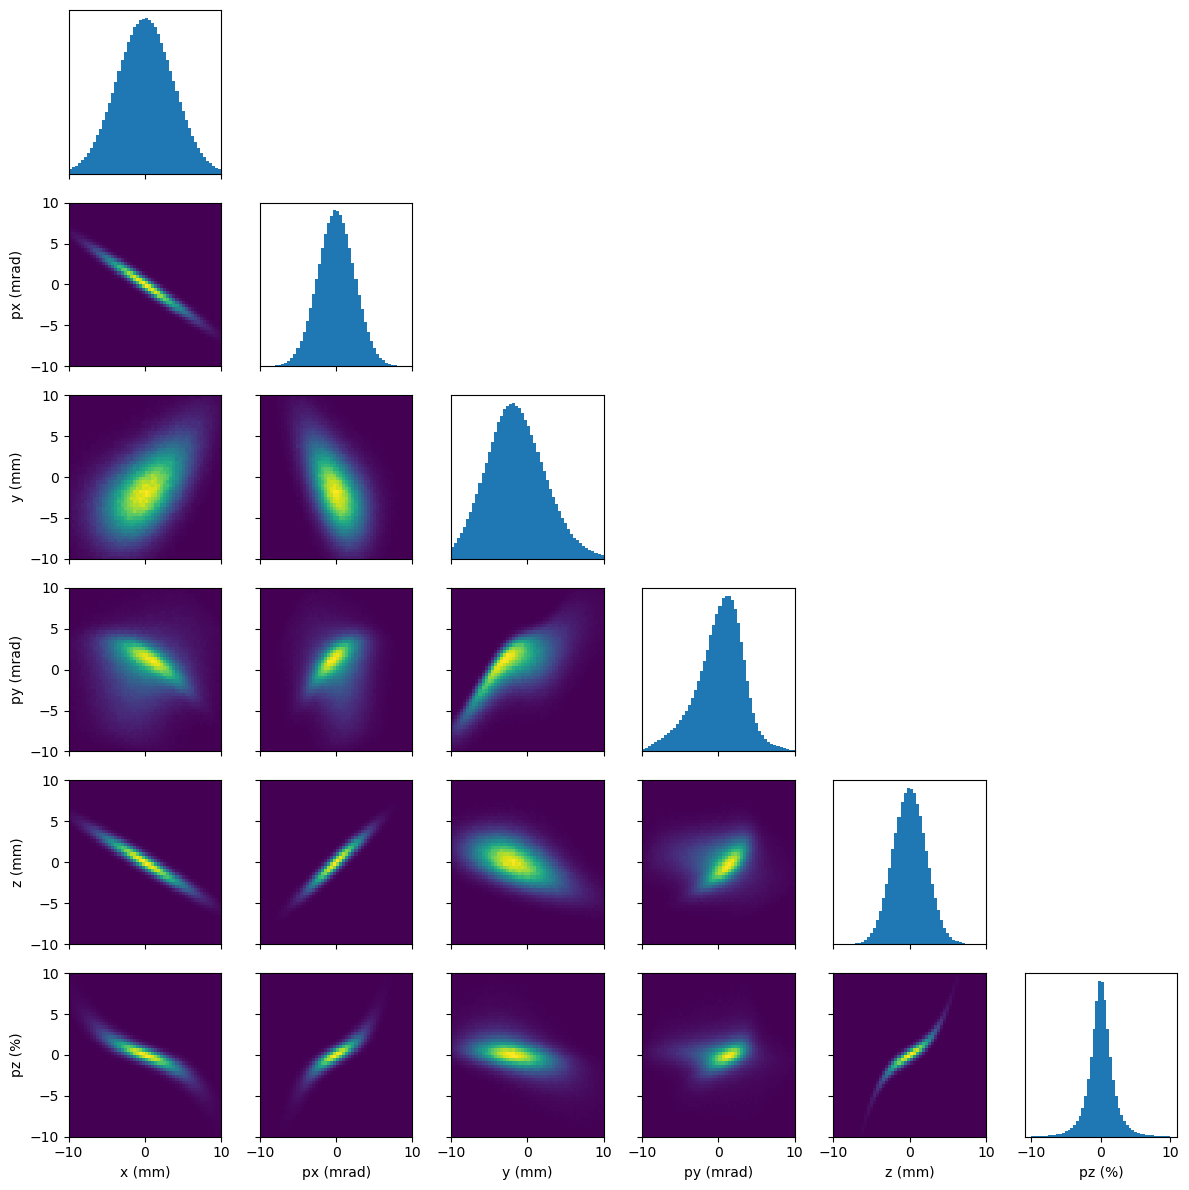

In [17]:
# plot gt:
lims = np.array([
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-2,10e-2]
])
plot_projections(gt_1.numpy_particles(), custom_lims=lims)
plt.show()

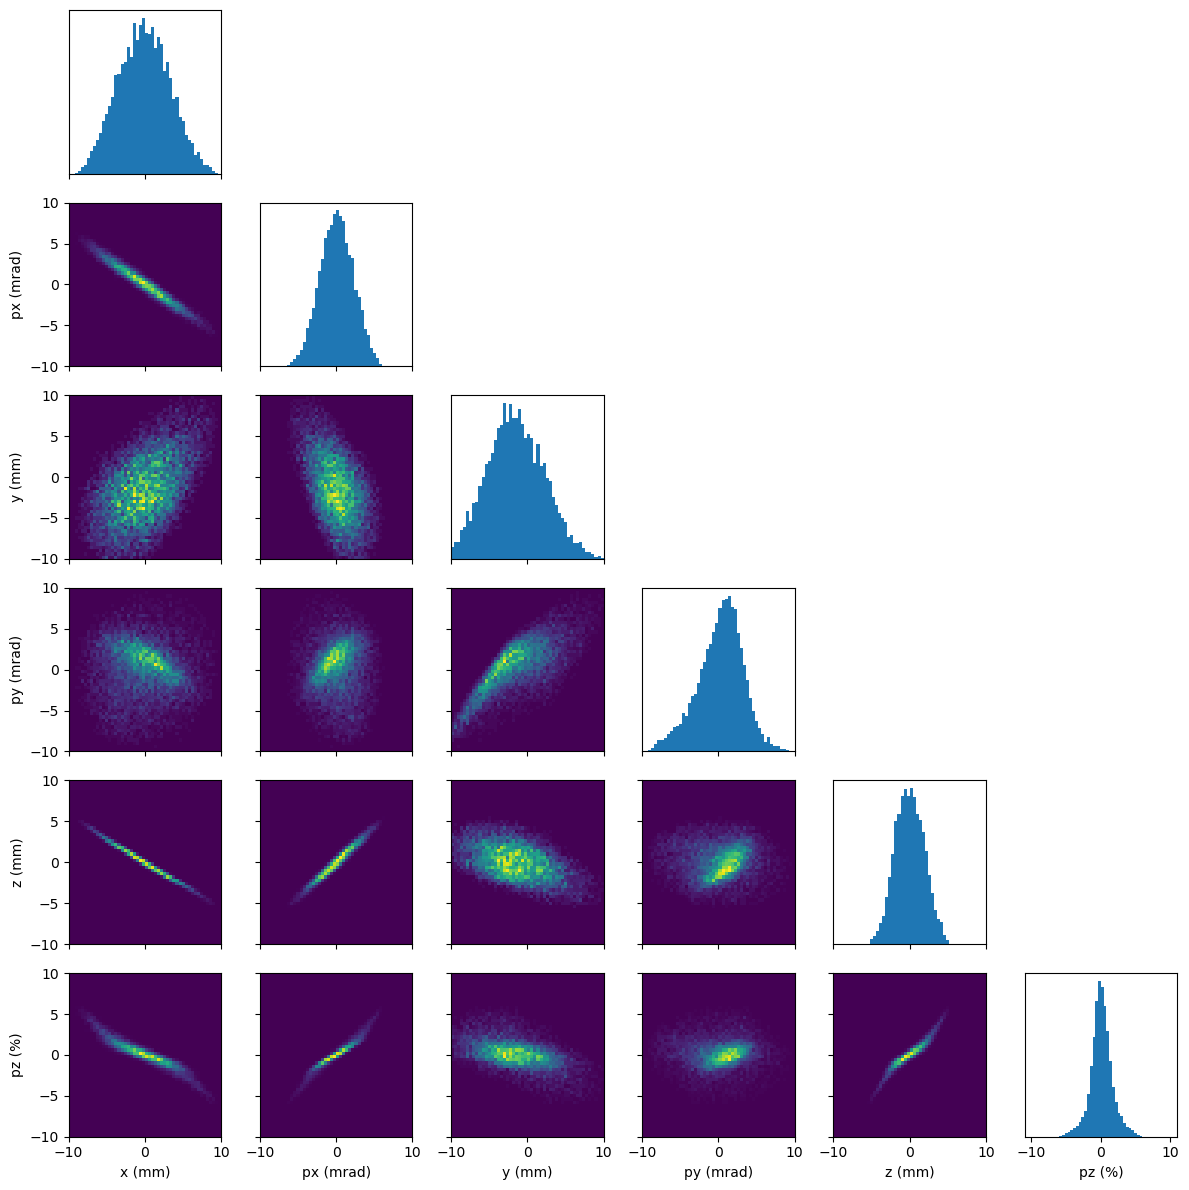

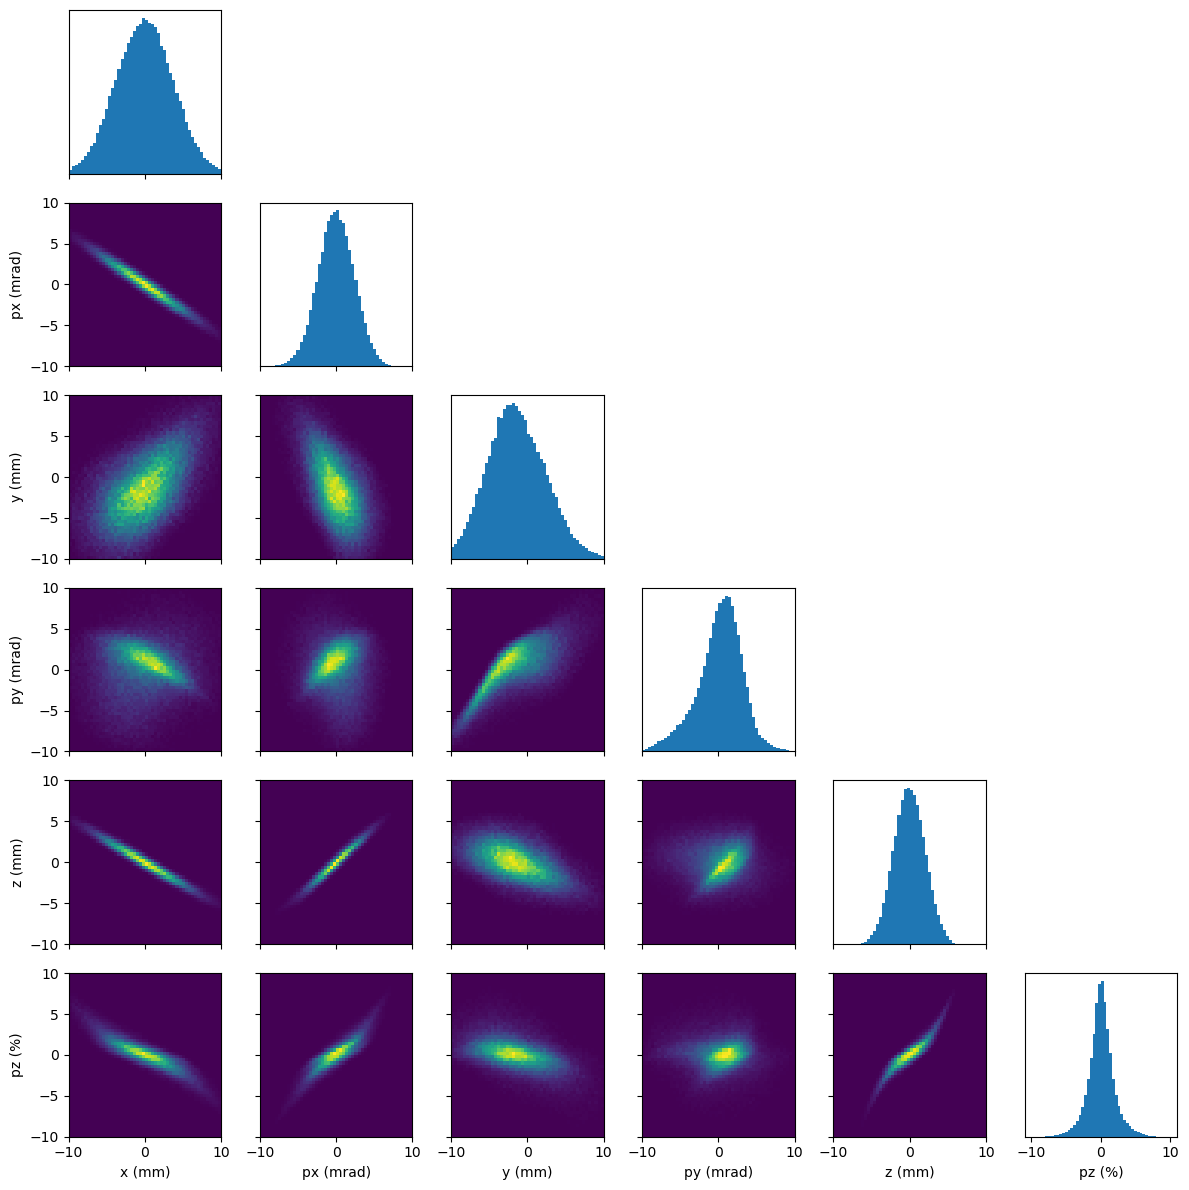

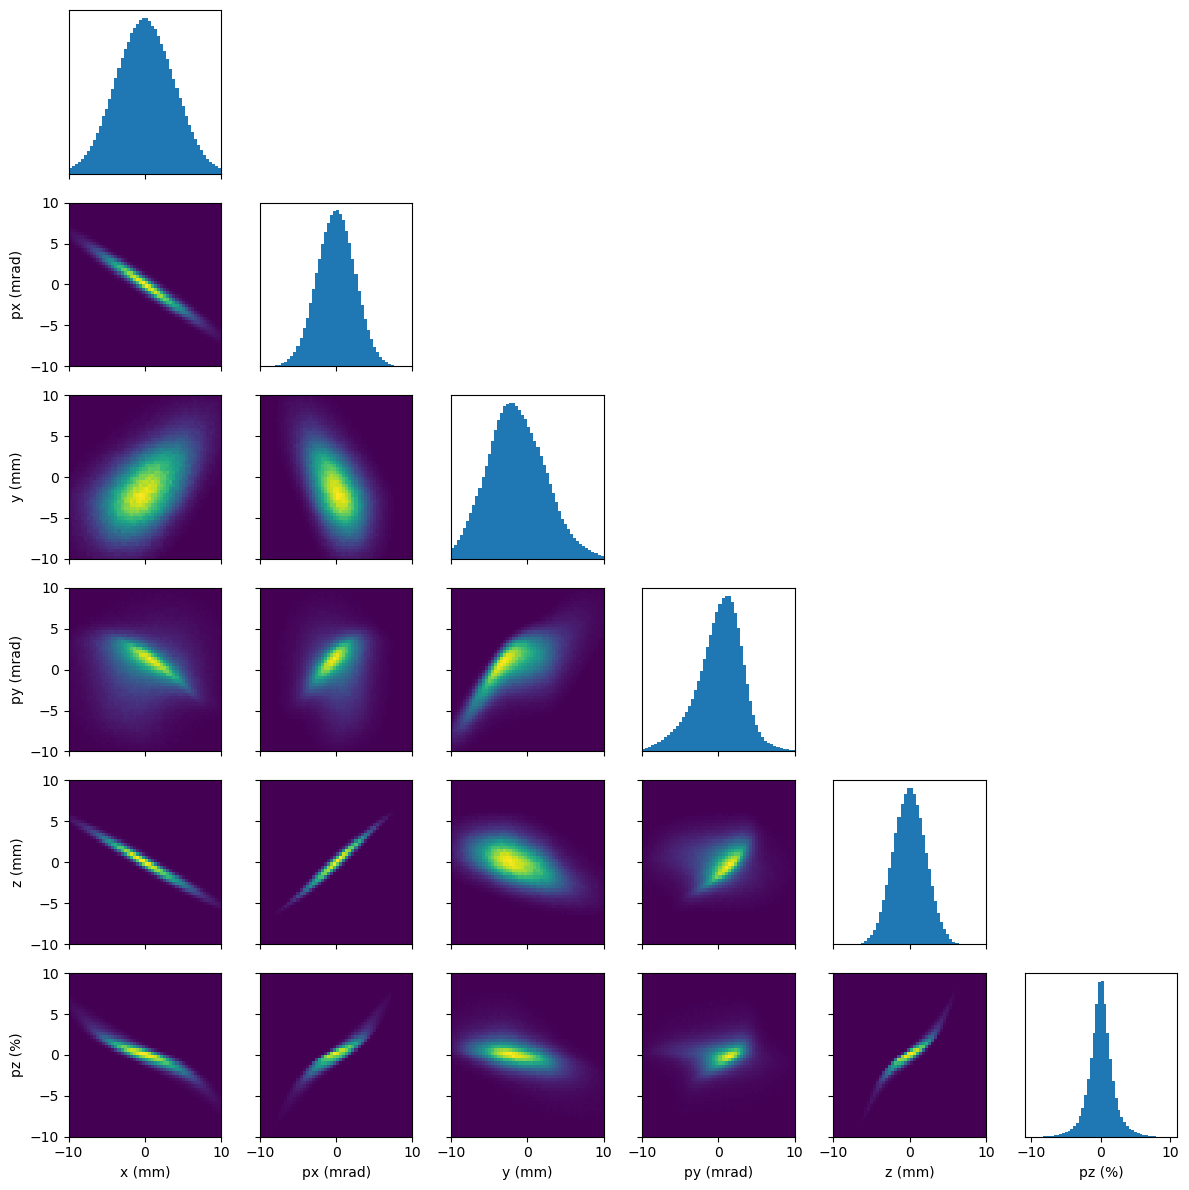

In [18]:
# plot recontructions:
plot_projections(r_10_000.numpy_particles(), custom_lims=lims)
plt.show()
plot_projections(r_100_000.numpy_particles(), custom_lims=lims)
plt.show()
plot_projections(r_1_000_000.numpy_particles(), custom_lims=lims)
plt.show()

In [32]:
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib.lines import Line2D

In [50]:
x = r_100_000.numpy_particles().x
px = r_100_000.numpy_particles().px
len(x)

100000

(array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 2., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([-1.20648192e-02, -1.18145812e-02, -1.15643433e-02, -1.13141053e-02,
        -1.10638673e-02, -1.08136293e-02, -1.05633914e-02, -1.03131534e-02,
        -1.00629154e-02, -9.81267745e-03, -9.56243947e-03, -9.31220150e-03,
        -9.06196352e-03, -8.81172555e-03, -8.56148757e-03, -8.31124960e-03,
        -8.06101162e-03, -7.81077364e-03, -7.56053567e-03, -7.31029769e-03,
        -7.06005972e-03, -6.80982174e-03, -6.55958377e-03, -6.30934579e-03,
        -6.05910782e-03, -5.80886984e-03, -5.55863187e-03, -5.30839389e-03,
        -5.05815592e-03, -4.80791794e-03, -4.55767997e-03, -4.30744199e-03,
        -4.05720402e-03, -3.80696604e-03, -3.55672807e-03, -3.30649009e-03,
        -3.05625211e-03, -2.80601414e-03, -2.55577616e-03, -2.30553

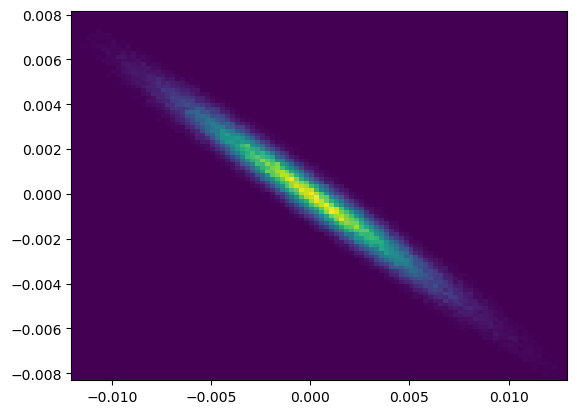

In [51]:
plt.hist2d(x, px, bins=[100,100])

In [67]:
hist, b_x, b_px = np.histogram2d(x, px, density=True, bins=[100,100])
np.shape(hist)

(100, 100)

In [68]:
vmax = hist.max()
vmax

87727.67654560518

In [69]:
test_levels = np.linspace(0, vmax, 100)
total = hist.sum()
total

24234164.791603718

In [70]:
sums = []
for ele in test_levels:
    sums += [np.where(hist >= ele, hist, 0.0).sum() / total]
sums = np.array(sums)

In [71]:
quantiles = [0.25,0.5,0.9,0.99]
levels = []
for ele in quantiles[::-1]:
    diff = sums - ele
    levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
clevels = np.array(levels).flatten()
x1c = (b_x[:-1] + b_x[1:]) / 2
x2c = (b_px[:-1] + b_px[1:]) / 2

In [76]:
X, Y = np.meshgrid(b_x,b_px)
Xc, Yc = np.meshgrid(x1c,x2c)
np.shape(Y)

(101, 101)

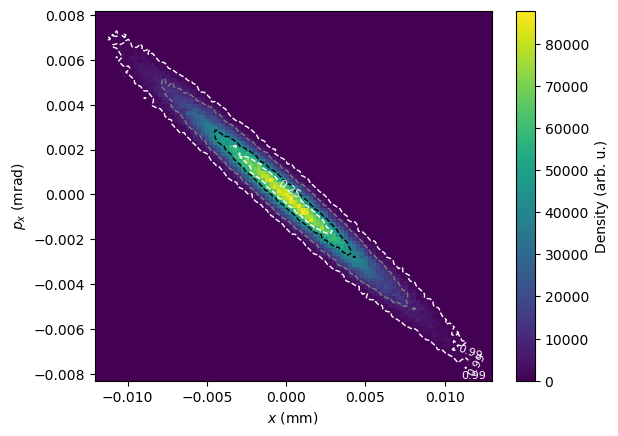

In [80]:
fig, ax = plt.subplots()
c1 = ax.imshow
c1 = ax.pcolor(X, Y, hist.T)
    #ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
c2 = ax.contour(Xc, Yc, hist.T, levels=clevels,linestyles="dashed",
                        colors=["black","grey","white"][::-1],linewidths=1)
ax.clabel(
                c2, inline=True, fontsize=8,
                fmt=dict(zip(clevels,[f"{ele}" for ele in quantiles[::-1]])),
                manual=[(1.5*kk/3, 0.15*kk/3) for kk in range(len(quantiles))]
            )
ax.set_xlabel(r"$x$ (mm)")
ax.set_ylabel(r"$p_x$ (mrad)")
cbar = fig.colorbar(c1,label="Density (arb. u.)")

# 3D scan vs 'T' scan

In [28]:
gt_2 = torch.load(os.path.join(t_scan_dir, 'non_gaussian_beam.pt'))
r_3d_scan = torch.load(os.path.join(t_scan_dir, '3D_scan_100_000.pt'))
r_t_scan = torch.load(os.path.join(t_scan_dir, 't_scan_100_000.pt'))

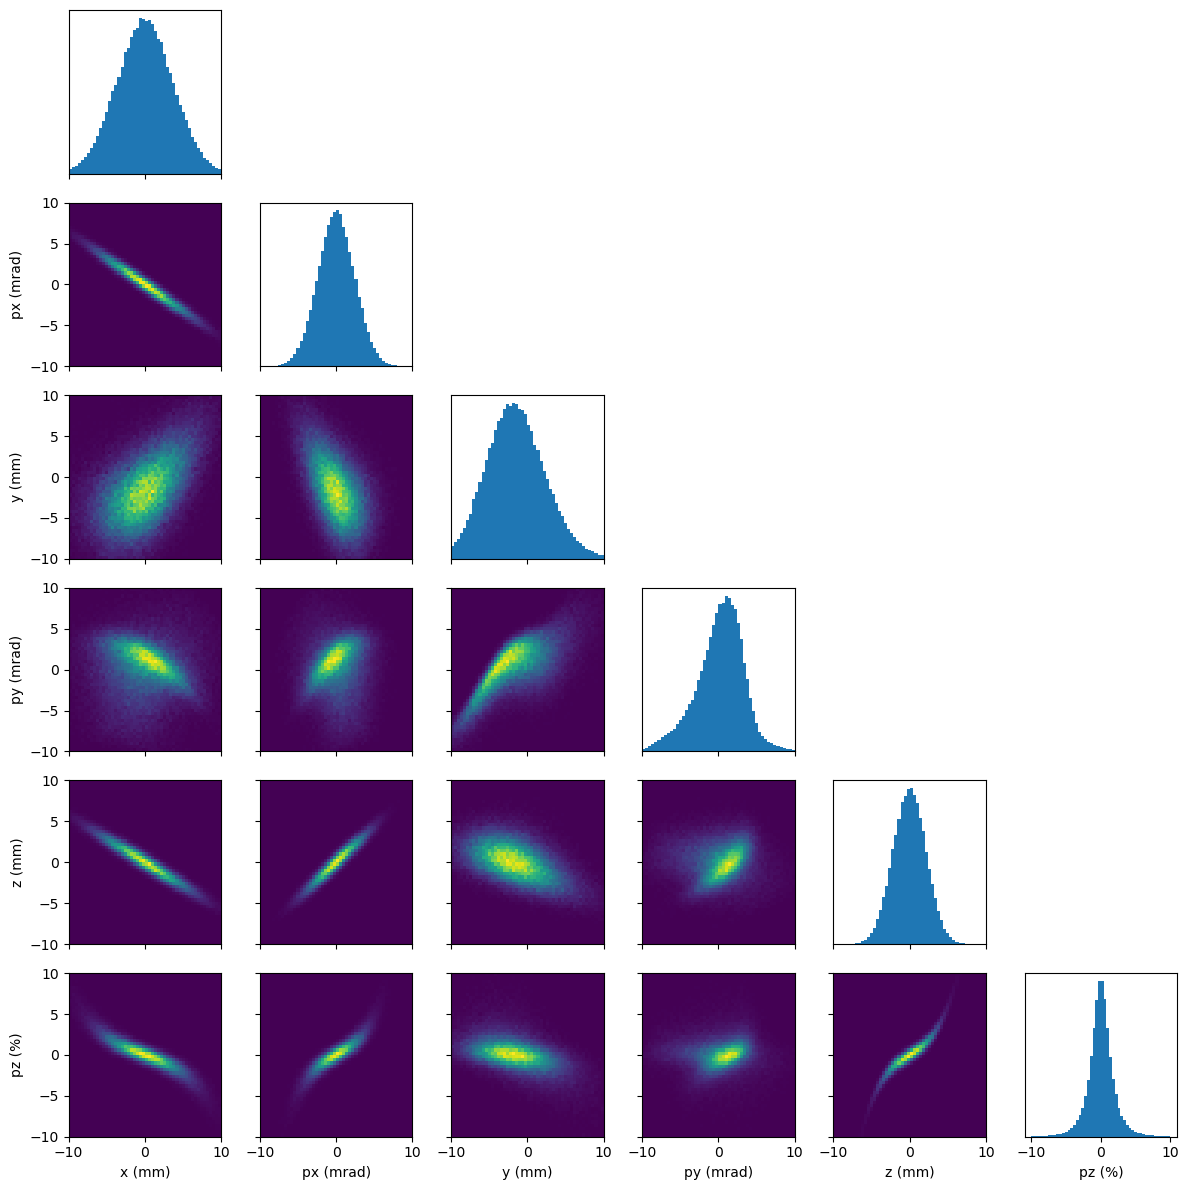

In [29]:
# plot ground truth beam:
plot_projections(gt_2.numpy_particles(), custom_lims=lims)
plt.show()

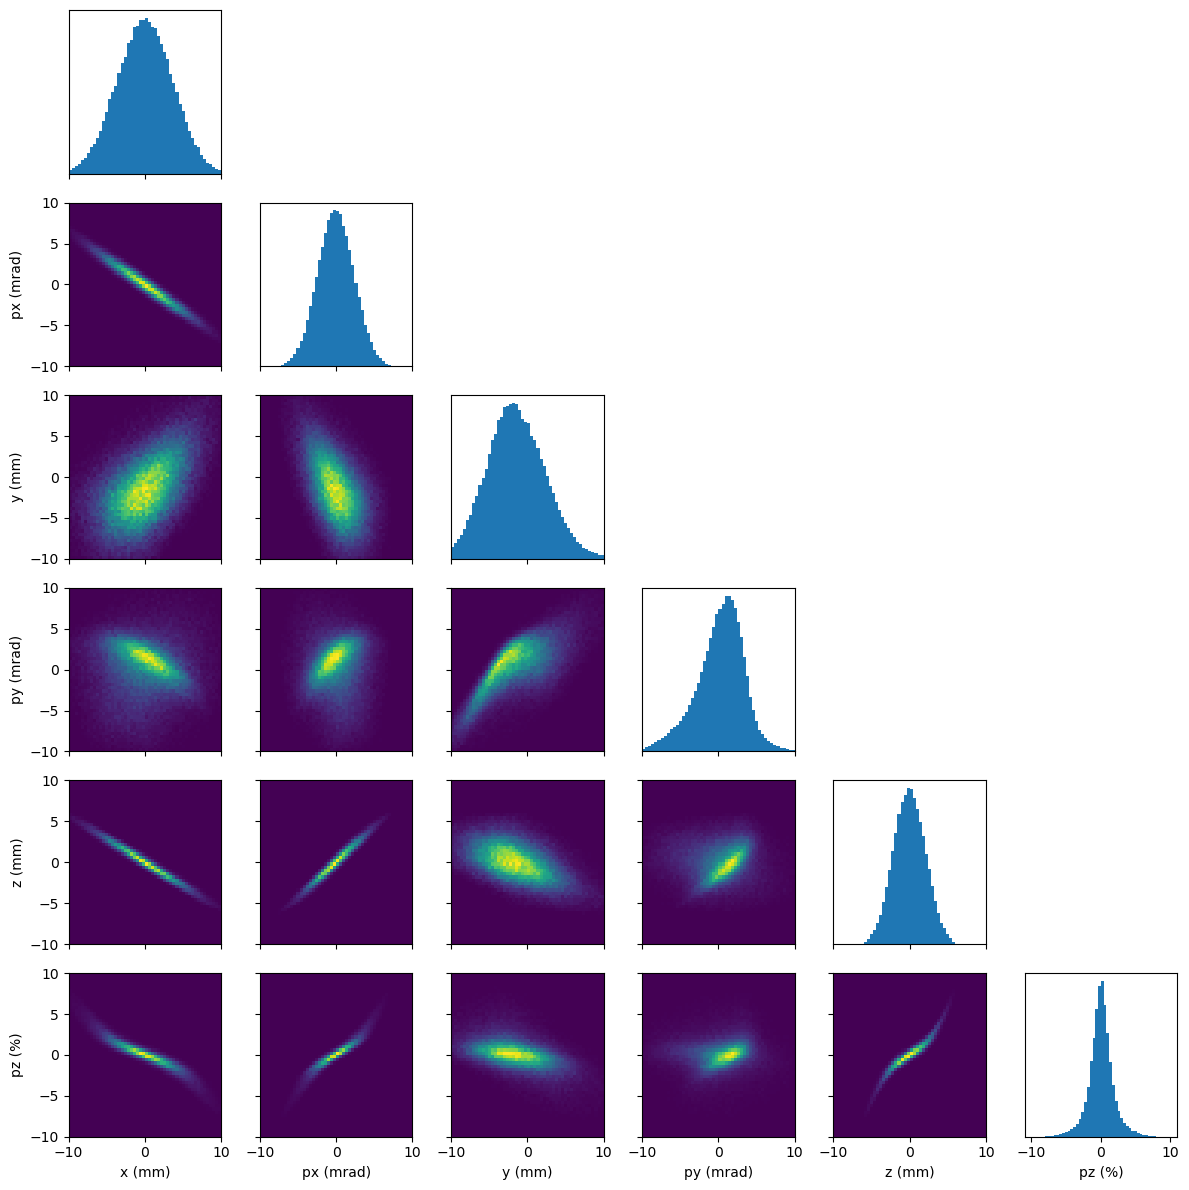

In [30]:
# plot 3d scan reconstructed beam
plot_projections(r_3d_scan.numpy_particles(), custom_lims=lims)
plt.show()

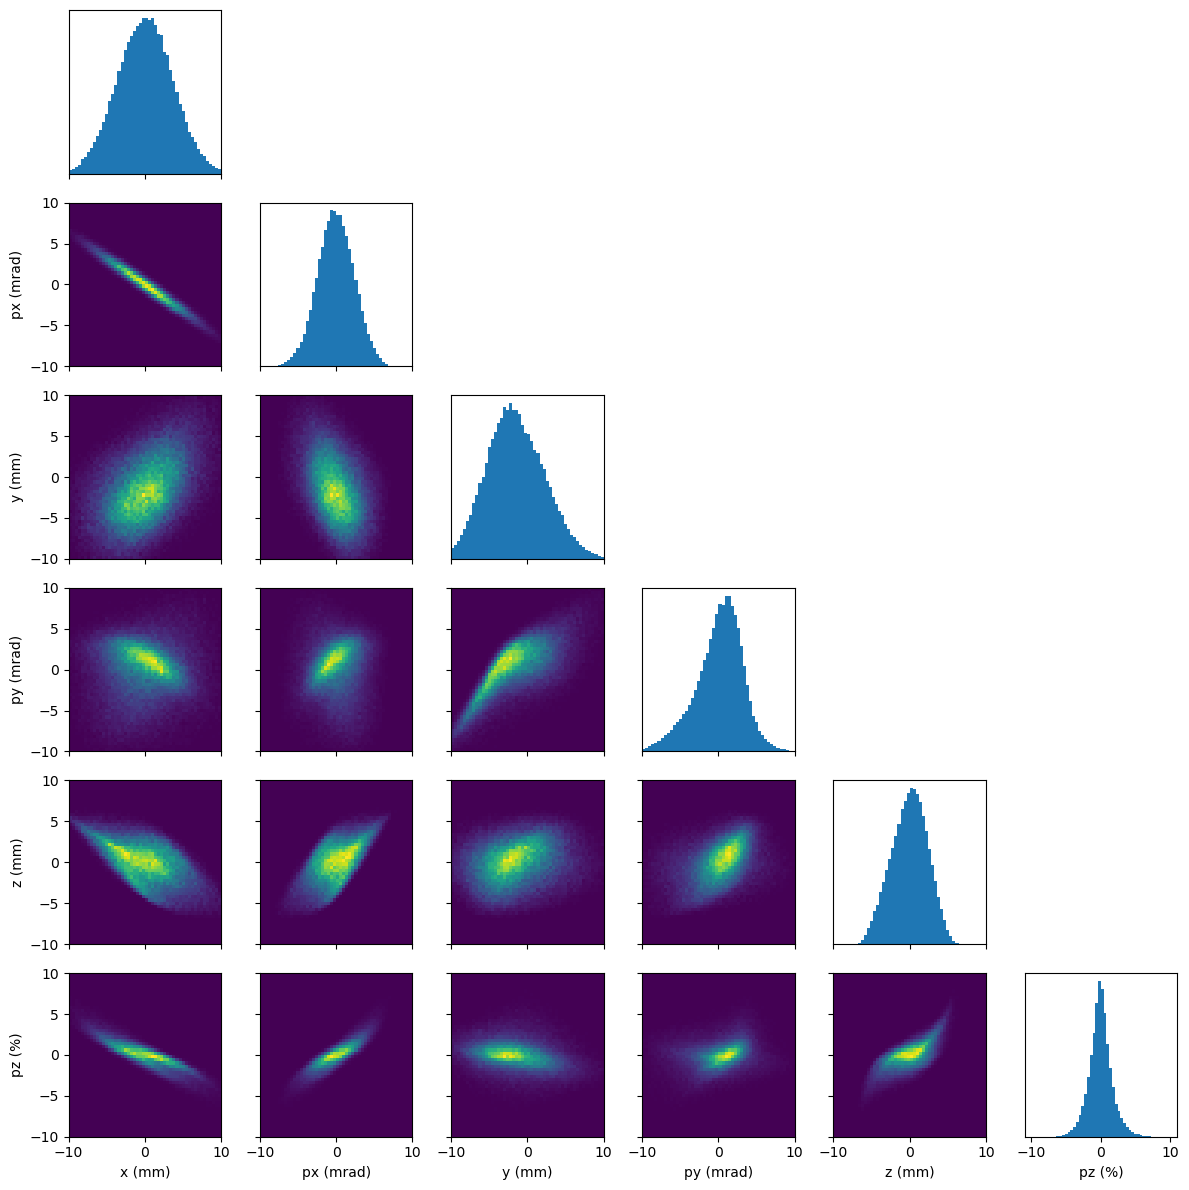

In [31]:
# plot t scan reconstructed beam
plot_projections(r_t_scan.numpy_particles(), custom_lims=lims)
plt.show()

In [23]:
beam_gt_frac_50 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.5)
beam_gt_frac_90 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.9)
beam_gt_frac_95 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.95)

beam_3d_frac_50 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.5)
beam_3d_frac_90 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.9)
beam_3d_frac_95 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.95)

beam_t_frac_50 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.5)
beam_t_frac_90 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.9)
beam_t_frac_95 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.95)

(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (%)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (%)'>]], dtype=object))

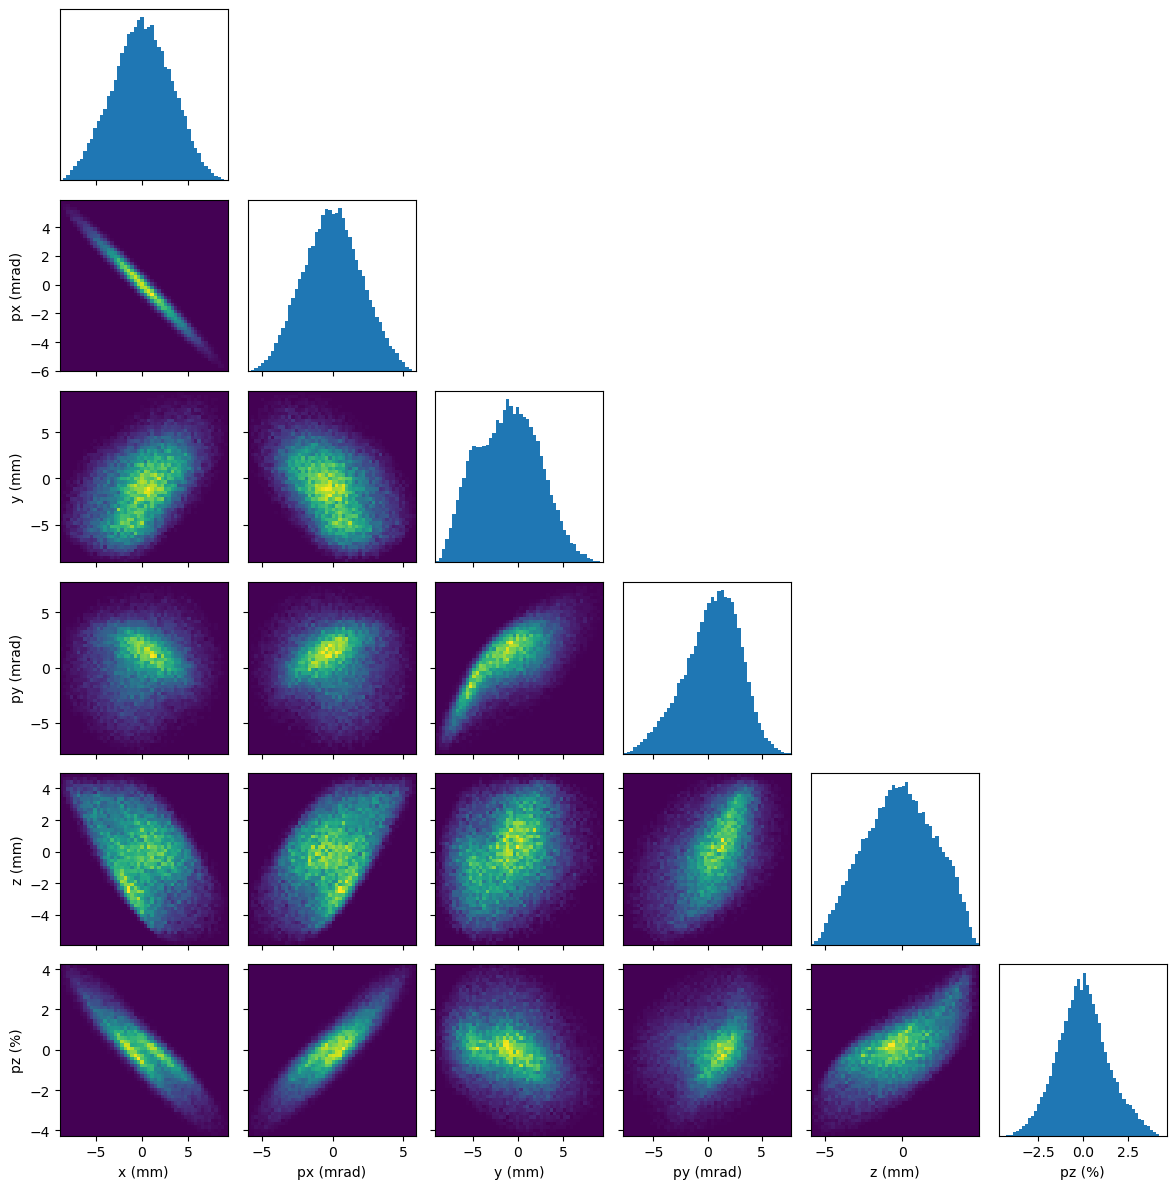

In [24]:
plot_projections(beam_t_frac_50.numpy_particles())

(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (%)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (%)'>]], dtype=object))

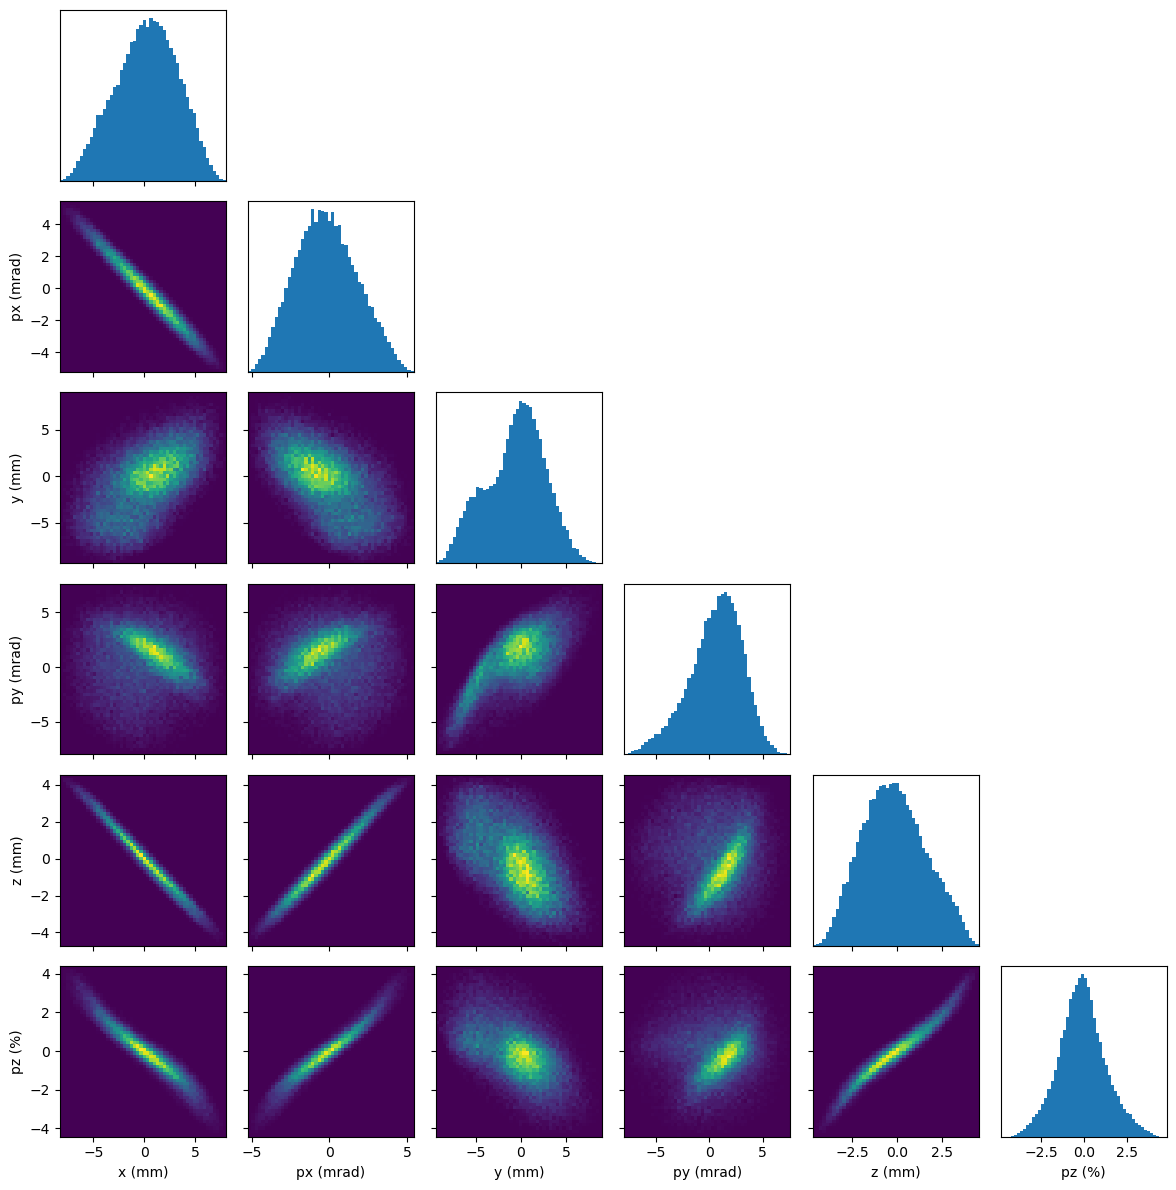

In [25]:
plot_projections(beam_3d_frac_50.numpy_particles())

(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (%)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (%)'>]], dtype=object))

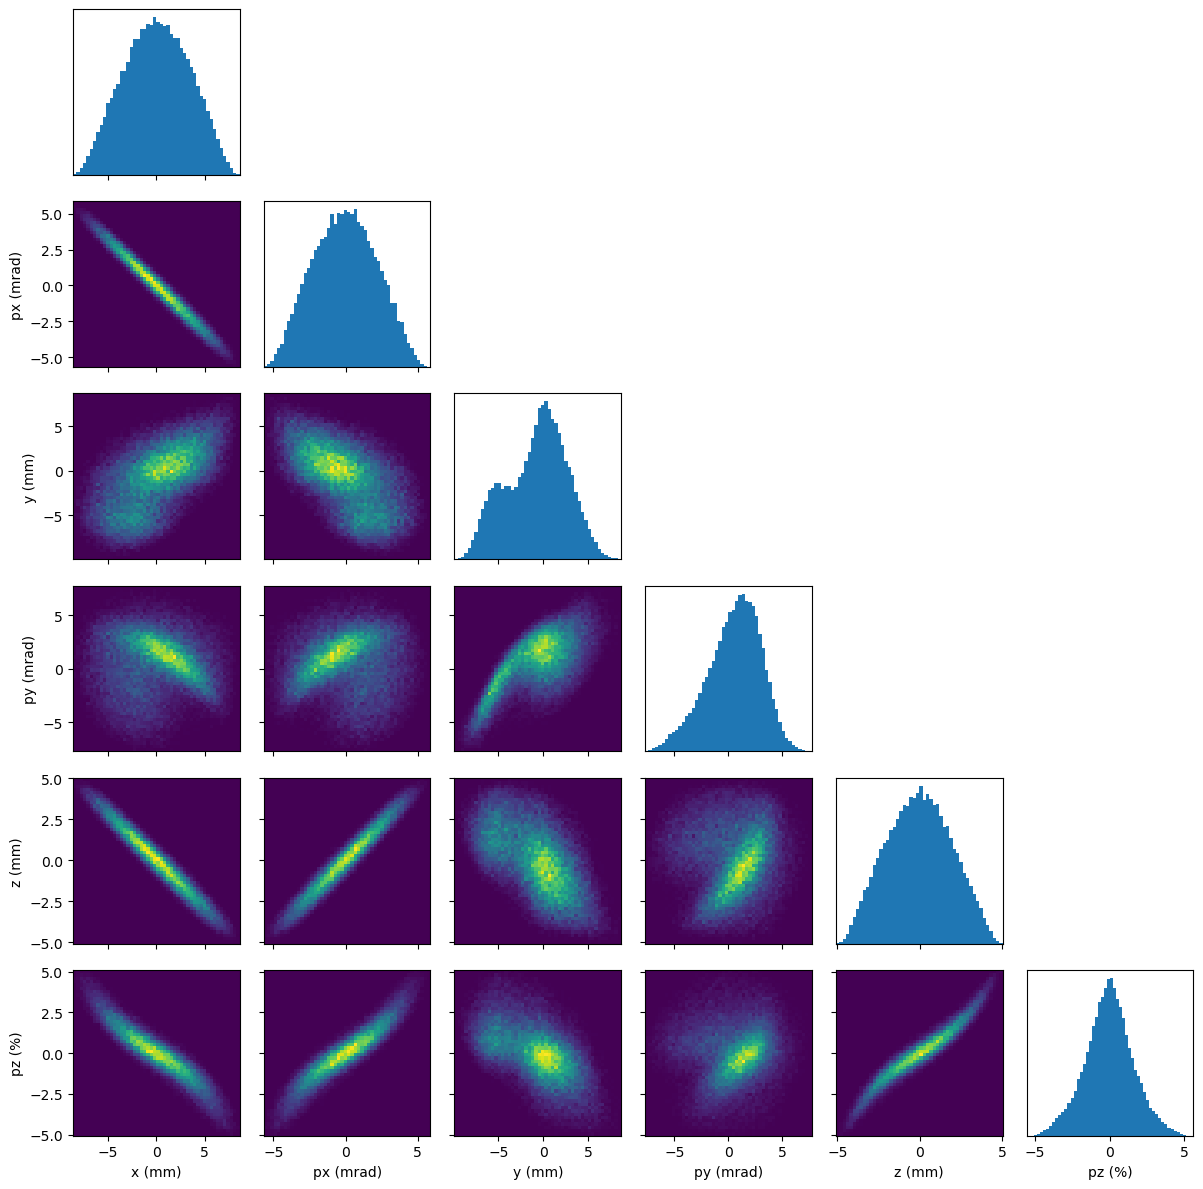

In [26]:
plot_projections(beam_gt_frac_50.numpy_particles())